In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True

# this is the package including the connection to YAeHMOP
from rdkit.Chem import rdEHTTools
from rdkit.Chem import AllChem
import numpy as np

import rdkit
print(rdkit.__version__)
import time
print(time.asctime())

2019.03.4
Fri Sep 27 10:45:03 2019


In [2]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


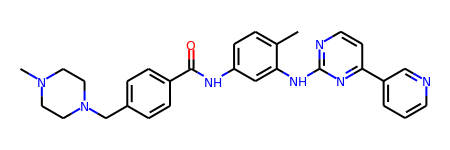

In [3]:
# imatinib
m = Chem.MolFromSmiles('Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1')
m

In [4]:
mh = Chem.AddHs(m)
AllChem.EmbedMultipleConfs(mh,50);

In [5]:
passed,res = rdEHTTools.RunMol(mh)


In [6]:
passed

True

In [7]:
res

In [8]:
res.GetAtomicCharges()


array([-4.76731370e-02, -1.82554407e-02, -4.19458147e-02, -1.22902698e-01,
        2.77950581e-01, -2.61806452e-01,  9.99377802e-01, -1.21974534e+00,
        1.34268202e-02, -2.32647560e-03, -5.91813840e-02,  7.73620993e-02,
        2.45477608e-01, -6.05239709e-01,  1.96875689e-01,  2.19275477e-01,
       -5.98947692e-01,  1.97951512e-01,  2.26523907e-01,  1.97779580e-01,
       -4.75784926e-02, -2.46739720e-04, -1.61793445e-01,  2.82286112e-01,
       -3.49019873e-01,  9.25183814e-01, -8.91513014e-01,  4.28411229e-01,
       -1.75792605e-01,  4.90044802e-01,  1.44798454e-02,  1.08341110e-01,
       -7.09763175e-02,  3.66440853e-01, -8.24839688e-01,  3.66154631e-01,
       -8.92945852e-01,  2.62834808e-02,  1.06946764e-02,  1.74631614e-02,
        1.25255149e-02,  2.44540515e-02,  2.15489103e-01,  2.70510531e-02,
        2.64733442e-02, -1.54172953e-02, -1.76464578e-02,  5.84765500e-03,
        8.41373067e-04, -4.58589987e-03, -3.51196182e-03, -8.61968874e-03,
        1.67566170e-03,  

In [9]:
res.GetReducedOverlapPopulationMatrix()[:6]


array([ 2.57813695,  0.79585516,  2.78412494, -0.08233683,  1.1324619 ,
        2.72546329])

In [10]:
# convenience function to set a "MulilkenOverlapPopulation" property on bonds.
def set_overlap_populations(m,ehtRes):
    rop = ehtRes.GetReducedOverlapPopulationMatrix()
    for bnd in m.GetBonds():
        a1 = bnd.GetBeginAtom()
        a2 = bnd.GetEndAtom()
        if a1.GetAtomicNum()==1:
            continue
        if a2.GetAtomicNum()==1:
            continue
        # symmetric matrix:
        i1 = max(a1.GetIdx(),a2.GetIdx())
        i2 = min(a1.GetIdx(),a2.GetIdx())
        idx = (i1*(i1+1))//2 + i2
        bnd.SetDoubleProp("MullikenOverlapPopulation",rop[idx])

In [11]:
set_overlap_populations(mh,res)


In [12]:
for bnd in list(mh.GetBonds())[:5]:
    if not bnd.HasProp("MullikenOverlapPopulation"):
        continue
    print(f'{bnd.GetIdx()} {bnd.GetBeginAtom().GetSymbol()}({bnd.GetBeginAtomIdx()})-{bnd.GetEndAtom().GetSymbol()}({bnd.GetEndAtomIdx()}) {bnd.GetBondType()} {bnd.GetDoubleProp("MullikenOverlapPopulation") :.3f}')

0 C(0)-C(1) SINGLE 0.796
1 C(1)-C(2) AROMATIC 1.132
2 C(2)-C(3) AROMATIC 1.088
3 C(3)-C(4) AROMATIC 1.109
4 C(4)-N(5) SINGLE 0.785


In [13]:
def runEHT(mh):
    """ convenience function to run an eHT calculation on all of a molecule's conformers
    
        returns a list of the results structures as well as a list of lists containing the
        charges on each atom in each conformer: chgs[atomId][confId] to use this
    """
    eres = []
    charges = [[] for x in range(mh.GetNumHeavyAtoms())]
    for cid in range(mh.GetNumConformers()):
        passed,res = rdEHTTools.RunMol(mh,confId=cid)
        eres.append(res)
        if not passed:
            raise ValueError("eHT failed")
        hvyIdx = 0
        echgs = res.GetAtomicCharges()
        for atom in mh.GetAtoms():
            if atom.GetAtomicNum()==1:
                continue
            charges[hvyIdx].append(echgs[atom.GetIdx()])
            hvyIdx+=1
    return (eres,charges)

In [14]:
eres,charges = runEHT(mh)


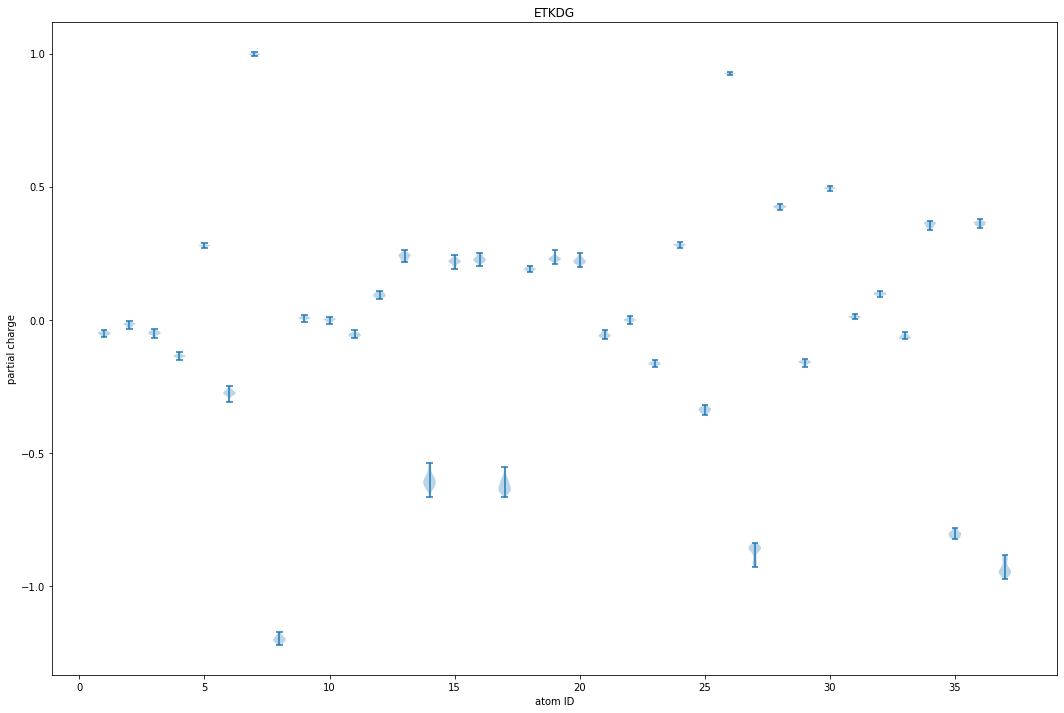

In [15]:
figsize(18,12)
violinplot(charges);
title("ETKDG");
xlabel('atom ID');
ylabel("partial charge");

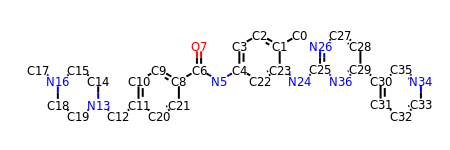

In [16]:
for at in m.GetAtoms():
    at.SetProp("atomLabel",f'{at.GetSymbol()}{at.GetIdx()}')
m

In [17]:
tchgs = sorted((y,x) for x,y in enumerate(charges[13]))
tchgs[:2],tchgs[-2:]


([(-0.6664029226533725, 6), (-0.6487594694999941, 48)],
 [(-0.5445165709857742, 17), (-0.5391876949925227, 16)])

In [19]:
tchgs = sorted((y,x) for x,y in enumerate(charges[1]))
tchgs[:2],tchgs[-2:]


([(-0.034432744017417916, 35), (-0.03245424527605956, 39)],
 [(-0.008412383261406697, 41), (-0.005217032331633398, 46)])

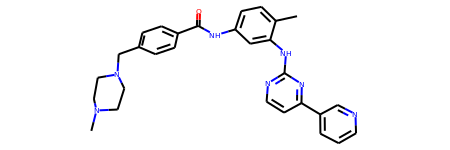

In [20]:
tm1 = Chem.MolFromMolBlock(Chem.MolToMolBlock(mh,confId=1))
tm1

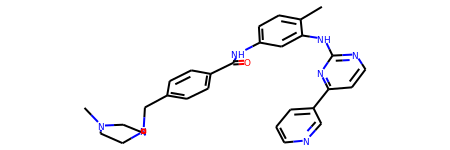

In [21]:
tm24 = Chem.MolFromMolBlock(Chem.MolToMolBlock(mh,confId=24))
tm24

In [22]:
tchgs = sorted((y,x) for x,y in enumerate(charges[36]))
tchgs[:2],tchgs[-2:]

([(-0.9757653597847145, 5), (-0.964269062711359, 39)],
 [(-0.8904366087667777, 2), (-0.8853126618481291, 25)])

In [23]:
chgs = sorted((y,x) for x,y in enumerate(charges[26]))
tchgs[:2],tchgs[-2:]

([(-0.9757653597847145, 5), (-0.964269062711359, 39)],
 [(-0.8904366087667777, 2), (-0.8853126618481291, 25)])

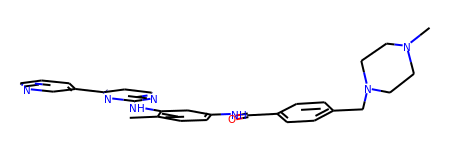

In [24]:

tm5 = Chem.MolFromMolBlock(Chem.MolToMolBlock(mh,confId=5))
tm5

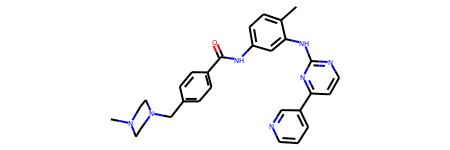

In [25]:
tm2 = Chem.MolFromMolBlock(Chem.MolToMolBlock(mh,confId=2))
tm2

In [26]:
mh_mmff = Chem.Mol(mh)
optRes = AllChem.MMFFOptimizeMoleculeConfs(mh_mmff,maxIters=500)
for i,needsMore in enumerate(optRes):
    while needsMore:
        needsMore = AllChem.MMFFOptimizeMolecule(mh_mmff,maxIters=500,confId=i)

In [27]:
eres,mmff_charges = runEHT(mh_mmff)


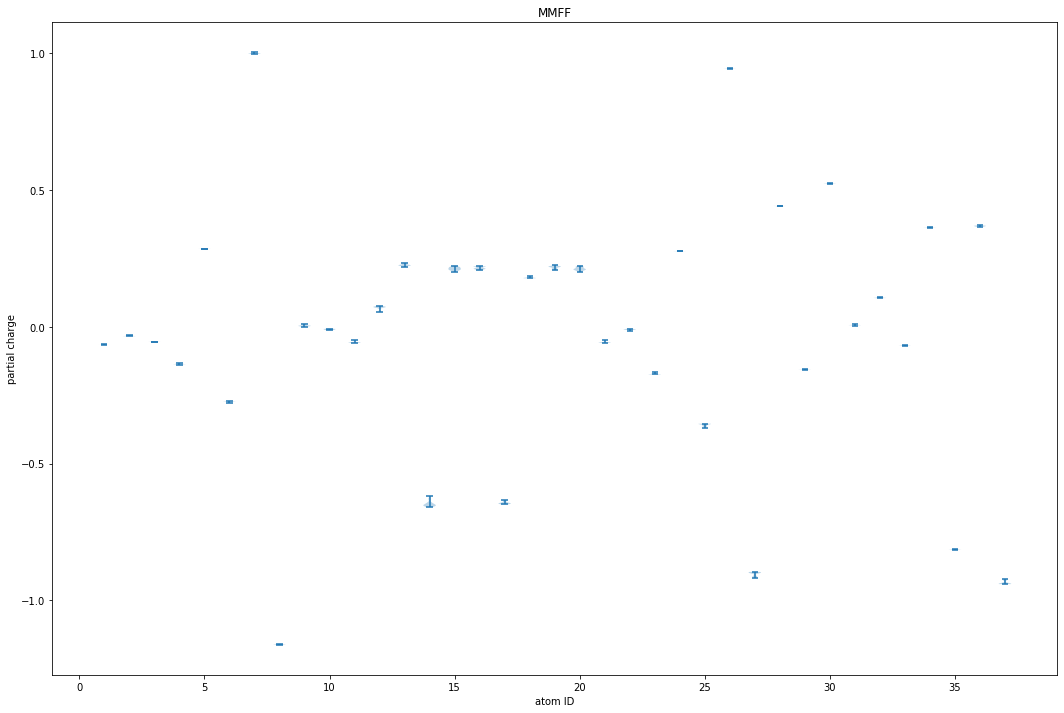

In [28]:
figsize(18,12)
violinplot(mmff_charges);
title("MMFF");
xlabel('atom ID');
ylabel("partial charge");

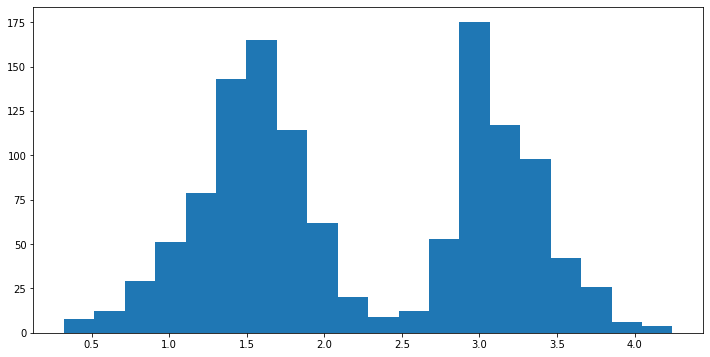

In [29]:

rmsds = []
cp1 = Chem.RemoveHs(mh_mmff)
cp2 = Chem.RemoveHs(mh_mmff)
for i in range(mh_mmff.GetNumConformers()):
    for j in range(i+1,mh_mmff.GetNumConformers()):
        rmsds.append(AllChem.GetBestRMS(cp1,cp2,prbId=i,refId=j))
figsize(12,6)
hist(rmsds,bins=20);

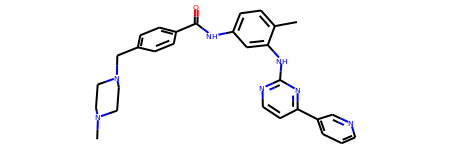

In [30]:
tm1 = Chem.MolFromMolBlock(Chem.MolToMolBlock(mh_mmff,confId=1))
tm1

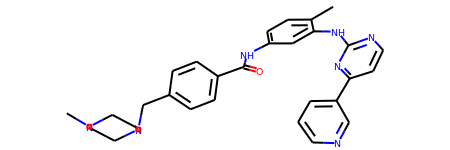

In [31]:
tm24 = Chem.MolFromMolBlock(Chem.MolToMolBlock(mh_mmff,confId=24))
tm24

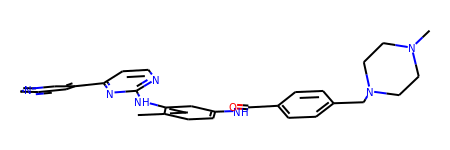

In [32]:
tm5 = Chem.MolFromMolBlock(Chem.MolToMolBlock(mh_mmff,confId=5))
tm5

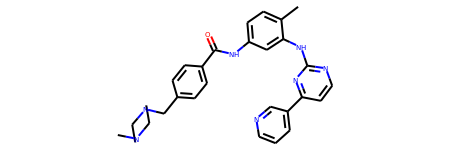

In [33]:
tm2 = Chem.MolFromMolBlock(Chem.MolToMolBlock(mh_mmff,confId=2))
tm2

In [34]:
charge_compare = []
for i in range(len(charges)):
    both = list(zip(charges[i],mmff_charges[i]))
    charge_compare.extend(both)

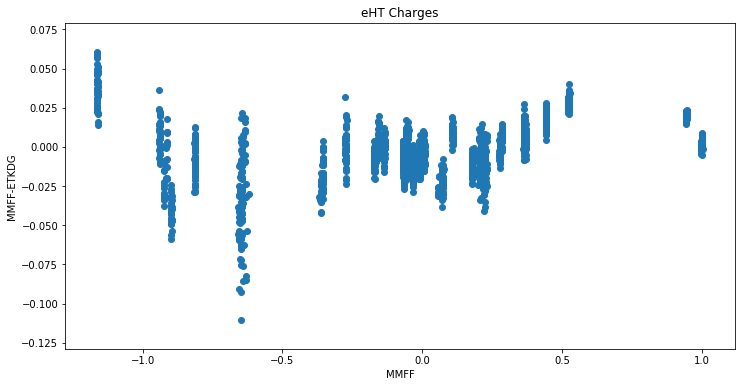

In [35]:
scatter([y for x,y in charge_compare],[y-x for x,y in charge_compare])
xlabel('MMFF')
ylabel('MMFF-ETKDG');
title('eHT Charges');

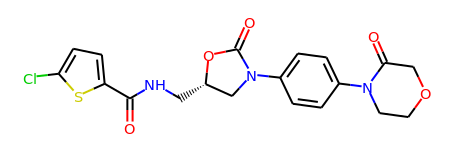

In [36]:
# rivaroxaban
m2 = Chem.MolFromSmiles('O=C(NC[C@H]1CN(c2ccc(N3CCOCC3=O)cc2)C(=O)O1)c1ccc(Cl)s1')
m2

In [37]:
mh2 = Chem.AddHs(m2)
AllChem.EmbedMultipleConfs(mh2,50)
mh2_mmff = Chem.Mol(mh2)
optRes = AllChem.MMFFOptimizeMoleculeConfs(mh2_mmff,maxIters=500)
for i,needsMore in enumerate(optRes):
    while needsMore:
        needsMore = AllChem.MMFFOptimizeMolecule(mh2_mmff,maxIters=500,confId=i)

In [38]:
eres,charges2 = runEHT(mh2)
eres,mmff_charges2 = runEHT(mh2_mmff)

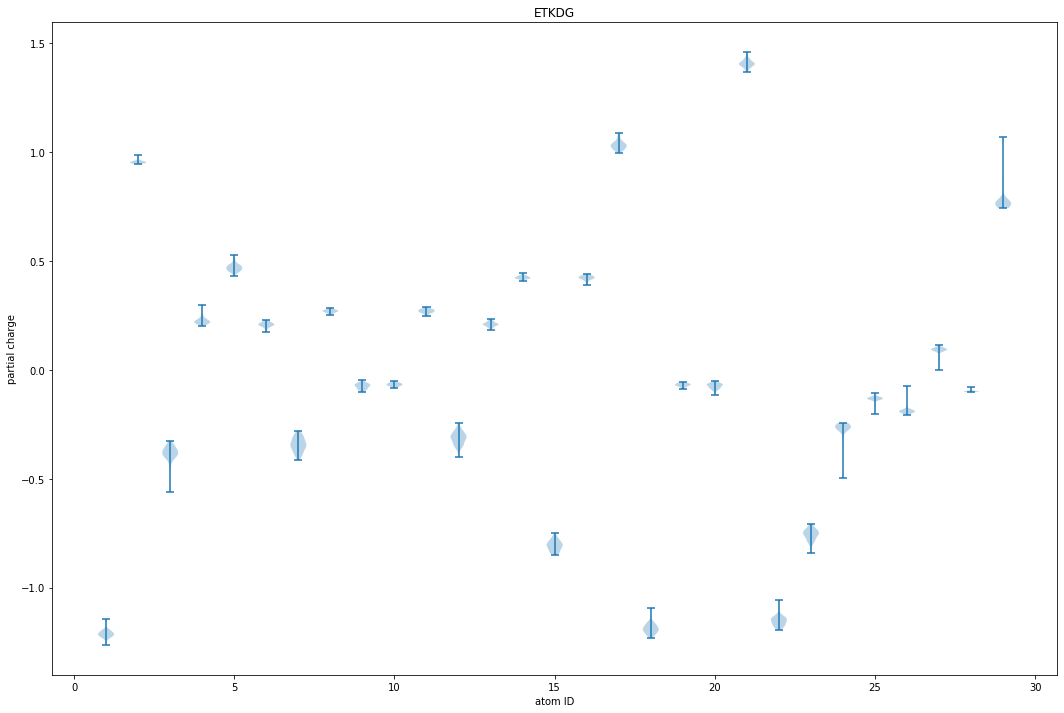

In [39]:
figsize(18,12)
violinplot(charges2);
title("ETKDG");
xlabel('atom ID');
ylabel("partial charge");

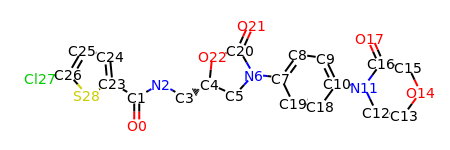

In [40]:
for at in m2.GetAtoms():
    at.SetProp("atomLabel",f'{at.GetSymbol()}{at.GetIdx()}')
m2

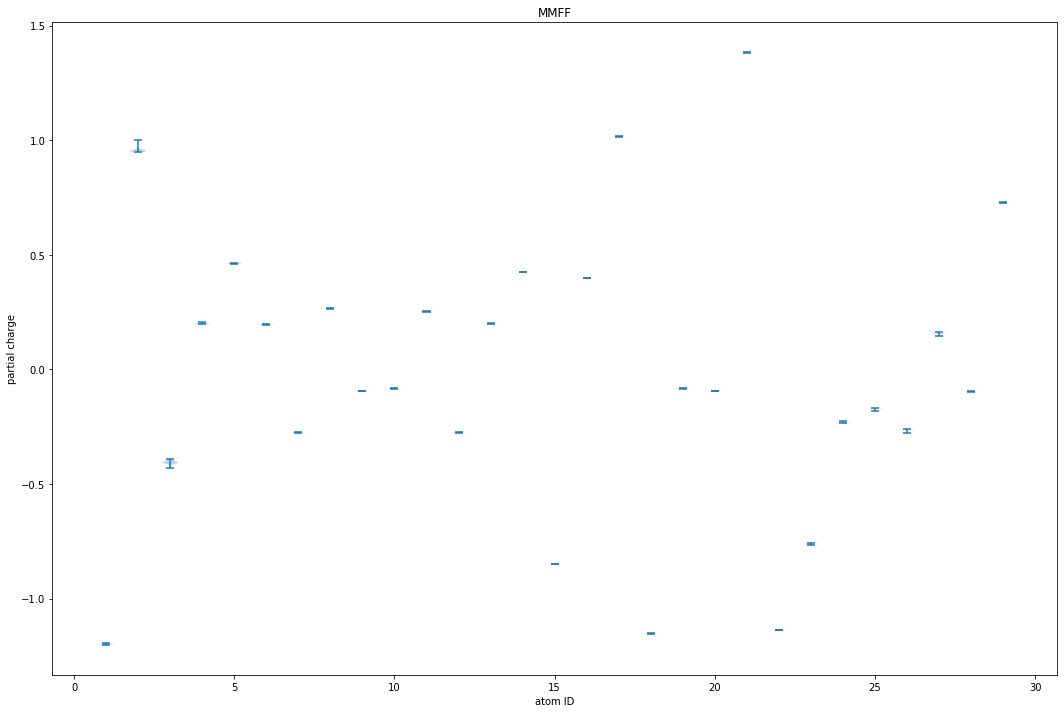

In [41]:
figsize(18,12)
violinplot(mmff_charges2);
title("MMFF");
xlabel('atom ID');
ylabel("partial charge");

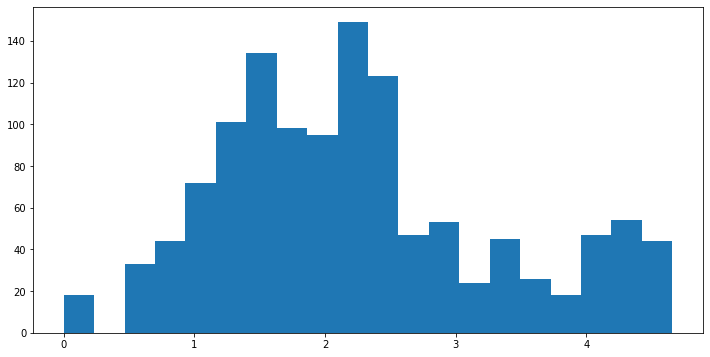

In [43]:
rmsds = []
cp1 = Chem.RemoveHs(mh2_mmff)
cp2 = Chem.RemoveHs(mh2_mmff)
for i in range(mh2_mmff.GetNumConformers()):
    for j in range(i+1,mh2_mmff.GetNumConformers()):
        rmsds.append(AllChem.GetBestRMS(cp1,cp2,prbId=i,refId=j))
figsize(12,6)
hist(rmsds,bins=20);

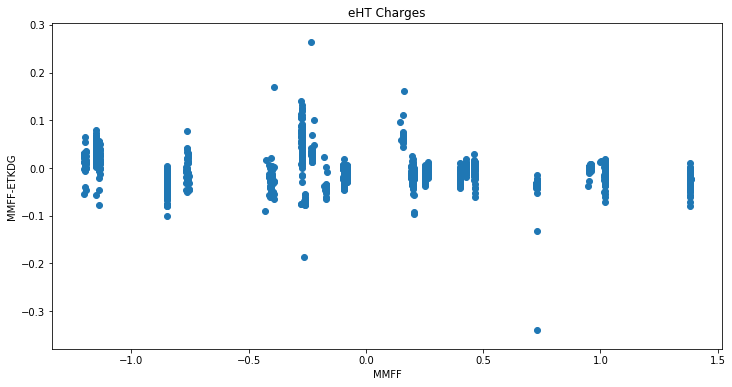

In [44]:
charge_compare2 = []
for i in range(len(charges2)):
    both = list(zip(charges2[i],mmff_charges2[i]))
    charge_compare2.extend(both)
scatter([y for x,y in charge_compare2],[y-x for x,y in charge_compare2])
xlabel('MMFF')
ylabel('MMFF-ETKDG');
title('eHT Charges');

In [45]:
tempM = Chem.Mol(mh2)
%timeit _ = AllChem.EmbedMolecule(tempM)

62.9 ms ± 3.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
%timeit _ = AllChem.EmbedMolecule(tempM);AllChem.MMFFOptimizeMolecule(tempM,maxIters=500)

164 ms ± 6.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [47]:
%timeit _ = rdEHTTools.RunMol(tempM)


58.5 ms ± 847 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
